# CS579: Assignment 1
## Collecting a political social network

In this assignment, I've given you a list of Twitter accounts of 15 U.S. presedential candidates.
The goal is to use the Twitter API to construct a social network of these accounts. We will then use the [networkx](http://networkx.github.io/) library to plot these links, as well as print some statistics of the resulting graph.

1. Copy the files from this directory into the `asg/a1` folder of your private repository.
2. Create an account on [twitter.com](http://twitter.com).
3. Generate authentication tokens by following the instructions [here](https://dev.twitter.com/docs/auth/tokens-devtwittercom).
4. Add your tokens to the `twitter.cfg` file. (API Key == Consumer Key)
5. Be sure you've installed the Python modules [networkx](http://networkx.github.io/) and [TwitterAPI](https://github.com/geduldig/TwitterAPI). Assuming you've already installed [pip](http://pip.readthedocs.org/en/latest/installing.html), you can do this with `pip install networkx TwitterAPI`.

OK, now you're ready to start collecting some data!

I've provided a partial implementation below. Your job is to complete the code where indicated.  
You only need to modify the 6 methods indicated by **#TODO**

Your output should match the samples provided below.

In [1]:
# Imports you'll need.
from collections import Counter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI

%matplotlib inline

In [2]:
# This method is done for you. Make sure to put your credentials in twitter.cfg.
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
print('Established Twitter connection.')

Established Twitter connection.


In [3]:
def read_candidates(filename):
    """ Read a list of usernames for U.S. presedential candidates
    Args:
      filename: The name of the text file containing in format:
         <twitter handle> <R or D for Republican or Democrat>
    Returns:
      A list of (string, string) tuples representing each (handle, party) pair.
    """
    # TODO
    return [(candidate, party) for candidate, party in map(lambda line:line.split(), open(filename))]
candidates = read_candidates('candidates.txt')
print('Read %d candidates' % len(candidates))
print('\n'.join(str(x) for x in candidates))

Read 15 candidates
('HillaryClinton', 'D')
('BernieSanders', 'D')
('MartinOMalley', 'D')
('JoeBiden', 'D')
('JimWebbUSA', 'D')
('realDonaldTrump', 'R')
('JebBush', 'R')
('RealBenCarson', 'R')
('marcorubio', 'R')
('ScottWalker', 'R')
('tedcruz', 'R')
('CarlyFiorina', 'R')
('GovMikeHuckabee', 'R')
('govchristie', 'R')
('DrRandPaul', 'R')


In [4]:
# separate candidates by party.
republicans = [c[0] for c in candidates if c[1] == 'R']
democrats = [c[0] for c in candidates if c[1] == 'D']
print('%d republicans, %d democrats' % (len(republicans), len(democrats)))

10 republicans, 5 democrats


In [5]:
# I've provided the method below to handle Twitter's rate limiting.
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request.
      params ..... A parameter dictionary for the request.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print >> sys.stderr, 'Got error:', request.text, '\nsleeping for 15 minutes.'
            sys.stderr.flush()
            time.sleep(61 * 15)

In [18]:
def get_friends(screen_name):
    """ Return a list of the users that this person follows on Twitter, up to 200.
    See https://dev.twitter.com/rest/reference/get/friends/list 
    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.
    
    Args:
        screen_name: a string of a Twitter screen name
    Returns:
        A list of strings, one per friend.
    Note: Many users follow more than 200 accounts; we will limit ourselves to
    the first 200 accounts returned.
    """
    twt_handler = robust_request(twitter, 'search/tweets', {'q' : screen_name ,'count' : 200, 'lang': 'en'})
    return [i['text'] for i in twt_handler]

get_friends('iphone :( since:2014-10-01')
    
    

[u"@HeirThomas @EliWright94 you he don't got no iPhone... :(",
 u'@sledgehammer70 sadly i cant send photo of PC as its boxed due to lack of games on it :( an i broke iphone dropped butter side down \U0001f914',
 u"@FitbitSupport restarted both &amp; no luck :( I can't see the flex at all in iPhone bluetooth settings, it should show up there right?",
 u'I want a new iPhone :(',
 u"@smollsinner I hate iPhone in general bc they don't last long enough... :(",
 u'@BrokenEli I kinda want one. Too bad my iPhone is a 4. :( That bitch would come in hand.',
 u'https://t.co/1253swzWmf when this relates to you so much :(',
 u'RT @lilalien040: @milliexmcgee fukkkk :( whta iphone is it',
 u'i\u2019m considering buying a $240 iphone case :(',
 u'@milliexmcgee fukkkk :( whta iphone is it',
 u'@allielizmac I once saw an ad where someone was trying to trade a dog for an iPhone :(',
 u'@OddRectangle Ios 9.1 shows a "cannot be downloaded" when trying to download MovieBox for non-jail broken iPhone :-(',
 

In [114]:
print "the  are \n",candidates

the  are 
[('HillaryClinton', 'D'), ('BernieSanders', 'D'), ('MartinOMalley', 'D'), ('JoeBiden', 'D'), ('JimWebbUSA', 'D'), ('realDonaldTrump', 'R'), ('JebBush', 'R'), ('RealBenCarson', 'R'), ('marcorubio', 'R'), ('ScottWalker', 'R'), ('tedcruz', 'R'), ('CarlyFiorina', 'R'), ('GovMikeHuckabee', 'R'), ('govchristie', 'R'), ('DrRandPaul', 'R')]


In [115]:
def get_all_friends(screen_names):
    """ Get the friends for all the users in usernames.
    I.e., call get_friends for all 15 candidates.
    Args:
        screen_names: a list of Twitter screen names, one per candidate
    Returns:
        a dict mapping each candidate's username (string) to a list of his/her friends (strings)
    """
    return {n: get_friends(n) for n in screen_names}
#candidate_names = map(lambda x:x[0], candidates)
#print candidate_names
#friends_of_candidates = get_all_friends(candidate_names)
#print [ len(f) for c,f in friends_of_candidates.iteritems()]

In [116]:
candidate2friends = get_all_friends(c[0] for c in candidates)

In [117]:
# Print the number of friends per candidate, sorted by candidate name.
def print_num_friends(candidate2friends):
    sorted_by_name = sorted(candidate2friends.iteritems(), key = lambda x:x[0])
    return "".join(["%s %s\n" % (k, len(v)) for k,v in sorted_by_name])
    
    
#candidate_names = map(lambda x:x[0], candidates)
#candidate2friends = get_all_friends(candidate_names)
#print_num_friends(candidate2friends)

In [119]:
# Who is the most popular friend? (i.e., which friend is followed by the most number of candidates?
def count_friends(candidate2friends):
    """ Count how often each friend is followed.
    Args:
        candidate2friends: a dict mapping each candidate to a list of friends
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter
    """
    # TODO
    friend_counter = Counter()
    for k,v in candidate2friends.iteritems():
        friend_counter.update(v)
    return friend_counter
    
    
candidate_names = map(lambda x:x[0], candidates)
candidate2friends = get_all_friends(candidate_names)
friend_counts = count_friends(candidate2friends)
print friend_counts.most_common(5)

[(u'megynkelly', 7), (u'BretBaier', 7), (u'joniernst', 5), (u'jaketapper', 4), (u'oreillyfactor', 4)]


In [120]:
# Who are the most popular friends by party?
print('popular Republican friends:')
republican_counts = count_friends({k: v for k, v in candidate2friends.items() if k in republicans})
print republican_counts.most_common(5)

print('popular Democrat friends:')
democrat_counts = count_friends({k: v for k, v in candidate2friends.items() if k in democrats})
print democrat_counts.most_common(5)

popular Republican friends:
[(u'megynkelly', 7), (u'BretBaier', 7), (u'joniernst', 5), (u'oreillyfactor', 4), (u'FoxNewsSunday', 4)]
popular Democrat friends:
[(u'GovernorHassan', 2), (u'NickGass', 2), (u'UniPolitica', 2), (u'POTUS', 2), (u'TheLeadCNN', 2)]


In [121]:
# Do any candidates from one party actually follow a candidate from another party?
def bipartisan_count(republicans, democrats, candidate2friends):
    print('How many Democrats does each Republican follow?')        
    for r in republicans:
        print('%20s %d' % (r, len(set(democrats) & set(candidate2friends[r]))))
    print('How many Republicans does each Democrat follow?')        
    for d in democrats:
        print('%20s %d' % (d, len(set(republicans) & set(candidate2friends[d]))))

bipartisan_count(republicans, democrats, candidate2friends)

How many Democrats does each Republican follow?
     realDonaldTrump 0
             JebBush 0
       RealBenCarson 0
          marcorubio 0
         ScottWalker 0
             tedcruz 0
        CarlyFiorina 0
     GovMikeHuckabee 0
         govchristie 0
          DrRandPaul 0
How many Republicans does each Democrat follow?
      HillaryClinton 0
       BernieSanders 0
       MartinOMalley 0
            JoeBiden 0
          JimWebbUSA 0


In [122]:
"""
Since there's no direct links between Republicans and Democrats, we propose a different measure.
For each Republican, we cound the number of friends they have that are followed by at least one Democrat.
E.g., If JebBush(R) follows one user, POTUS, and HillaryClinton(D) also follows POTUS, then JebBush will have score 1.
"""
def score_republicans(republicans, democrats, democrat_counts, candidate2friends):
    """
    Args:
        republicans...list of strings, one per Republican
        democrats.....list of strings, one per Democrat
        democrat_counts...string-int dict mapping each friend to the number of Democrats who follow thiem.
        candidate2friends...string-list dict mapping each candidate to their list of friends.
    Returns:
        A list of (string, int) pairs, one per Republican candidate, indicating the number
        of friends the Republican has that are also followed by at least one Democrat.
    """
    common_friends = [(rep, len(set(democrat_counts.keys()) & set(candidate2friends[rep]))) for rep in republicans]
    return common_friends
    
republican_scores = score_republicans(republicans,democrats,democrat_counts, candidate2friends)
print 'How many second-degree Democratic friends does each Republican have?'
print '\n'.join('%20s %d' % (x[0], x[1]) for x in sorted(republican_scores, key=lambda x: x[1], reverse=True))

How many second-degree Democratic friends does each Republican have?
     GovMikeHuckabee 5
             JebBush 4
             tedcruz 3
         govchristie 3
          DrRandPaul 2
       RealBenCarson 1
         ScottWalker 1
        CarlyFiorina 1
     realDonaldTrump 0
          marcorubio 0


In [123]:
def create_graph(candidate2friends, friend_counts):
    """ Create a networkx DiGraph, adding each candidate/friend as a node. 
        Note: while all candidates should be added to the graph,
        only add friends for which friend_counts[friend] > 1. (This is to reduce clutter.)
    Args:
      candidate2friends: dict mapping each candidate to the list of friends
      friend_counts
    Returns:
      A networkx DiGraph
    """
    
    G = nx.DiGraph()
    #print 'length of friends with count > 1 is', len([f for f,count in friend_counts.iteritems() if count > 1])
    #print [(c1,len(v1))for c1,v1 in candidate2friends.iteritems()]
    #for f,count in friend_counts.iteritems():
    #    if count > 1:
    #        G.add_node(f)
    
    
    for cand, followed in candidate2friends.iteritems():
            G.add_node(cand)
            for follow in followed:
                if friend_counts[follow] > 1:
                    G.add_edge(cand, follow)
    return G
    
graph = create_graph(candidate2friends, friend_counts)
print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))

graph has 131 nodes and 279 edges


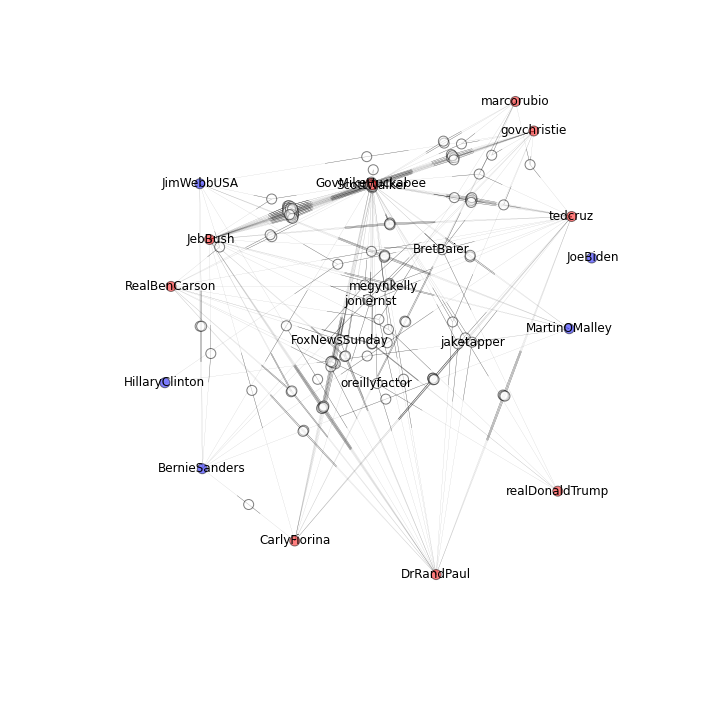

In [124]:
def get_color(name, republicans, democrats):
    if name in republicans:
        return 'r'
    elif name in democrats:
        return 'b'
    else:
        return 'w'

def draw_network(graph, republicans, democrats, candidate2friends, friend_counts):
    colors = [get_color(name, republicans, democrats) for name in graph.nodes()]
    labels = {n: n if n in candidate2friends or friend_counts[n] > 3 else '' for n in graph.nodes()}
    plt.figure(figsize=(12,12))
    nx.draw_networkx(graph, node_color=colors,
                     labels=labels, alpha=.5, width=.1,
                     node_size=100)
    plt.axis("off")
    plt.show()
    
draw_network(graph, republicans, democrats, candidate2friends, friend_counts)

In [125]:
# This will write some information to a text file, which we'll use to help grading.
# Be sure to run this code once at the end and check the resulting file (output.txt) into Github.
import json
outf = open('output.txt', 'wt')
json.dump({'candidates': sorted(candidates),
            'republicans': sorted(republicans),
            'democrats': sorted(democrats),
            'republican_counts': sorted(count_friends({k: v for k, v in candidate2friends.items() if k in republicans}).most_common(10)),
            'democrat_counts': sorted(count_friends({k: v for k, v in candidate2friends.items() if k in democrats}).most_common(10)),
            'num_nodes': len(graph.nodes()),
            'num_edges': len(graph.edges()),
            'republican_scores': sorted(republican_scores),
          }, outf, indent=2, sort_keys=True)
outf.close()

That's it for now! This should give you an introduction to some of the data we'll study in this course.